In [1]:
import numpy as np
import pandas as pd

In [2]:
X_train = pd.read_pickle("../data/X_train.pkl")
X_train_basic = np.load("../data/X_train_basic.npy")
X_train_freq = np.load("../data/X_train_freq.npy")
X_train_ite = np.load("../data/X_train_ite.npy")
y_train = np.load("../data/y_train.npy")

# Performance Evaluation

In [4]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlepad"] = 10.0
plt.rcParams["axes.titlelocation"] = "left"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
import seaborn as sns

In [5]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix

## Confusion Matrix

The function `cross_val_predict` returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. It is not appropriate for measuring generalisation error but suited for comparing different models.

In [6]:
X_train = X_train_freq

In [20]:
names = ["Constant Prediction",
         "Random Prediction",
         "K-Nearest Neighbors",
         "Gaussian Naive Bayes",
         "Decision Tree",
         "Logistic Regression"]

clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        KNeighborsClassifier(n_neighbors=3), 
        GaussianNB(),
        DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
        LogisticRegression(class_weight="balanced")]

n = len(names)
y_pred = {}
for name, clf in zip(names, clfs):
    y_pred[name] = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1)

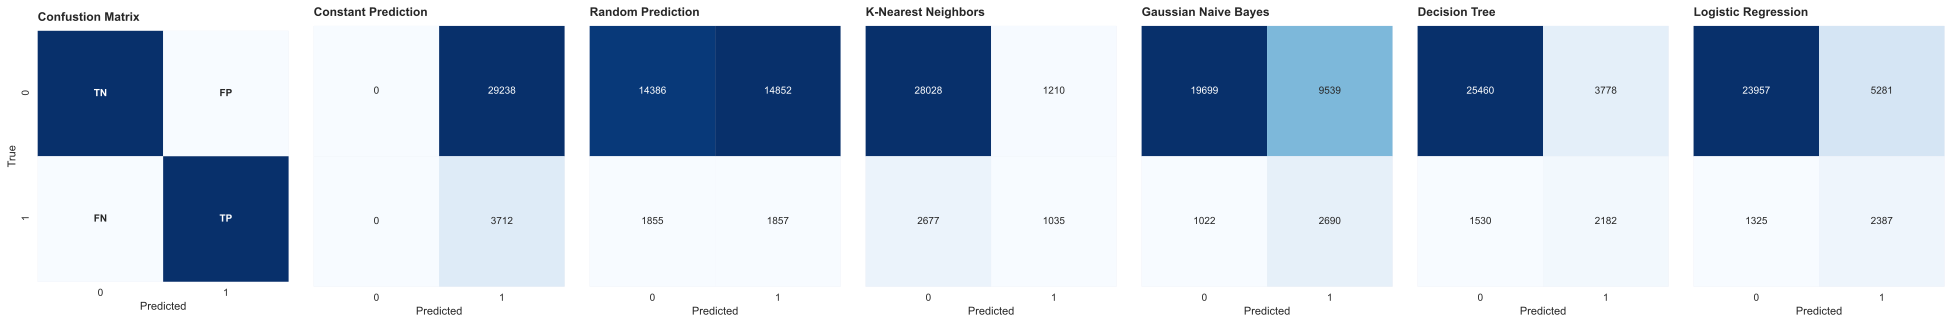

In [21]:
f, axs = plt.subplots(1, n+1, figsize=(4.8*(n+1)+0.1*n, 4.8), sharey=True, gridspec_kw=dict(wspace=0.1))

conf_mat = np.array([[100, 30], [30, 100]])
conf_label = np.array([["TN", "FP"], ["FN", "TP"]])
conf_ax = sns.heatmap(conf_mat,
                      ax=axs[0],
                      annot=conf_label,
                      annot_kws={"fontweight": "bold"},
                      fmt="",
                      square=True,
                      cmap=plt.cm.Blues, 
                      cbar=False)
conf_ax.set_xlabel("Predicted")
conf_ax.set_ylabel("True")
conf_ax.set_title("Confustion Matrix")

for i, name in zip(range(1, n+1), names):
    conf_mat = confusion_matrix(y_train, y_pred[name])
    conf_ax = sns.heatmap(conf_mat, 
                          ax=axs[i], 
                          annot=True, 
                          fmt="", 
                          cmap=plt.cm.Blues, 
                          cbar=False)
    conf_ax.set(xlabel="Predicted", title=name)

## Performance Matrics

From the Confusion Matrix, we can deride some key performance metrics.

The false positive rate (FPR) measures the error rate of the negative outcomes:

$$
FPR = \frac{FP}{N} = \frac{FP}{FP+TN}
$$

The true negative rate (TNR) measures the accuracy rate for the negative outcomes:

$$
TNR = \frac{TP}{N} = \frac{TN}{TN+FP} = 1 - FPR
$$

The true positive rate (TPR) measures the accuracy rate for the positive outcomes:

$$
TPR = \frac{TP}{P} = \frac{TP}{TP+FN}
$$

Balanced accuracy is the average of true positive rate and true negative rate:

$$
bACC = \frac{TPR+TNR}{2}
$$

True positive rate is also known as recall (REC):

$$
REC = TPR = \frac{TP}{TP+FN}
$$

Precision (PRE) measures the accuracy of the predicted positive outcomes:

$$
PRE = \frac{TP}{TP+FP}
$$

To balance the up- and down-sides of optimizing PRE and REC, the harmonic mean of precision and recall is used:

$$
F_1 = 2 \cdot \frac{PRE \times REC}{PRE + REC}
$$

In [22]:
matric_names = ["TNR", "TPR", "bACC", "REC", "PRE", "F1"]
matric_df = pd.DataFrame(index=matric_names, columns=names)

for name, clf in zip(names, clfs):
    matrics = [recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name]),
               balanced_accuracy_score(y_train, y_pred[name]),
               recall_score(y_train, y_pred[name]),
               precision_score(y_train, y_pred[name]),
               f1_score(y_train, y_pred[name])]
    matric_df[name] = matrics

matric_df

,Constant Prediction,Random Prediction,K-Nearest Neighbors,Gaussian Naive Bayes,Decision Tree,Logistic Regression
TNR,0.000000,0.492031,0.958616,0.673746,0.870785,0.819379
TPR,1.000000,0.500269,0.278825,0.724677,0.587823,0.643050
bACC,0.500000,0.496150,0.618720,0.699212,0.729304,0.731214
REC,1.000000,0.500269,0.278825,0.724677,0.587823,0.643050
PRE,0.112656,0.111138,0.461024,0.219969,0.366107,0.311294
F1,0.202498,0.181872,0.347490,0.337495,0.451199,0.419508


## Precision-Recall Curve and Receiver Operating Characteristic Curve

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [24]:
y_score = {}
for name, clf in zip(names, clfs):
    if name == "Logistic Regression":
        response_method = "decision_function"
    else:
        response_method = "predict_proba"
    y_score[name] = cross_val_predict(clf,
                                      X_train_freq,
                                      y_train,
                                      cv=10,
                                      n_jobs=-1,
                                      method=response_method)
    if name == "Logistic Regression":
        pass
    elif name == "Gaussian Naive Bayes":
        y_score[name] = y_score[name][:, 1] - y_score[name][:, 0]
    else:
        y_score[name] = y_score[name][:, 1]

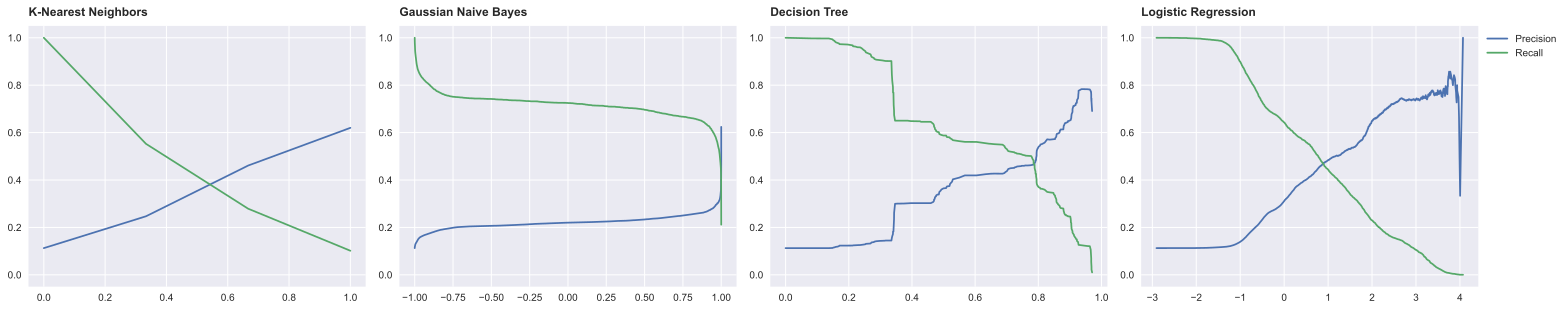

In [25]:
f, axs = plt.subplots(1, n-2, figsize=(6.4*(n-2)+0.1*(n-2), 4.8), gridspec_kw=dict(wspace=0.1))

for i, name in zip(range((n-2)), names[2:]):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precision_recall_df = pd.DataFrame({"Precision": precisions[:-1], "Recall": recalls[:-1]}, index=thresholds)
    ax = precision_recall_df.plot.line(ax=axs[i], ylim=(-0.05,1.05), legend=False, title=name)
    if i == n-3:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

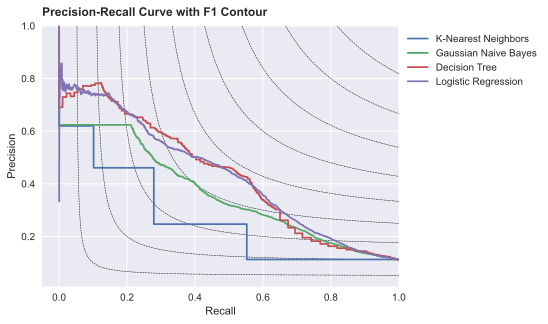

In [36]:
fig, ax = plt.subplots()

def f1(x, y):
    return 2*x*y/(x+y)

x = np.linspace(0.01,1,100)
y = np.linspace(0.01,1, 100)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    ax.plot(recalls, precisions, drawstyle="steps-post", label=name)

ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve with F1 Contour")

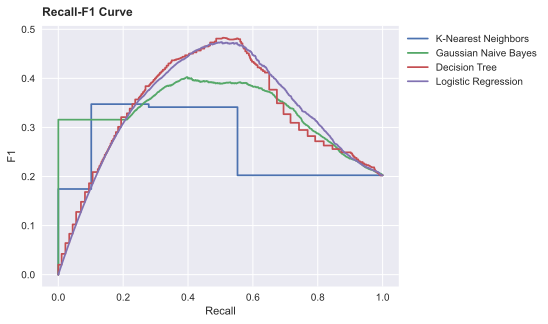

In [27]:
fig, ax = plt.subplots()
for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    ax.plot(recalls, 2*recalls*precisions/(recalls+precisions), drawstyle="steps-post", label=name)
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="F1", title="Recall-F1 Curve")

Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.

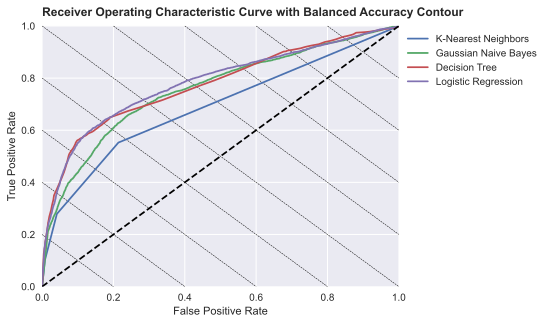

In [35]:
fig, ax = plt.subplots()

def bacc(x, y):
    return (x+y)/2

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x, y)
Z = bacc(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    fpr, tpr, thresholds = roc_curve(y_train, y_score[name])
    ax.plot(fpr, tpr, label=name)
ax.plot([0, 1], [0, 1], "k--")
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="False Positive Rate",
                ylabel="True Positive Rate",
                title="Receiver Operating Characteristic Curve with Balanced Accuracy Contour")

“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.” 

In [29]:
matric_names = ["TNR", "TPR", "bACC", "ROC AUC", "REC", "PRE", "F1", "AP"]
matric_df = pd.DataFrame(index=matric_names, columns=names)

for name, clf in zip(names, clfs):
    matrics = [recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name]),
               balanced_accuracy_score(y_train, y_pred[name]),
               roc_auc_score(y_train, y_score[name]),
               recall_score(y_train, y_pred[name]),
               precision_score(y_train, y_pred[name]),
               f1_score(y_train, y_pred[name]),
               average_precision_score(y_train, y_score[name])]
    matric_df[name] = matrics

matric_df

,Constant Prediction,Random Prediction,K-Nearest Neighbors,Gaussian Naive Bayes,Decision Tree,Logistic Regression
TNR,0.000000,0.492031,0.958616,0.673746,0.870785,0.819379
TPR,1.000000,0.500269,0.278825,0.724677,0.587823,0.643050
bACC,0.500000,0.496150,0.618720,0.699212,0.729304,0.731214
ROC AUC,0.500000,0.500000,0.688716,0.756385,0.774387,0.781619
REC,1.000000,0.500269,0.278825,0.724677,0.587823,0.643050
PRE,0.112656,0.111138,0.461024,0.219969,0.366107,0.311294
F1,0.202498,0.181872,0.347490,0.337495,0.451199,0.419508
AP,0.112656,0.112656,0.262710,0.362642,0.430247,0.432588
